In [1]:
# !pip install hmmlearn
# !pip install quantstats
# !pip install dtale

In [1]:
import datetime
import numpy as np
import pylab as pl
import pandas as pd
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from hmmlearn.hmm import GaussianHMM

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import yfinance as yf

import quantstats as qs
qs.extend_pandas()

import seaborn as sns
sns.set_style('whitegrid')

import plotly.io as pio
pio.renderers.default = "jupyterlab"

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

np.random.seed(42)

import dtale

SHILLER_DATA_URL = 'http://www.econ.yale.edu/~shiller/data/ie_data.xls'

%matplotlib inline

In [2]:
###############################################################################
# Downloading the data
date1 = datetime.date(2014, 1, 1)  # start date
date2 = datetime.date(2022, 1, 1)  # end date
# get quotes from yahoo finance
tickers = 'SPY ^VIX ^GSPC'
quotes = yf.download(tickers, start=date1, end=date2)
if len(quotes) == 0:
    raise SystemExit

[*********************100%***********************]  3 of 3 completed


In [37]:
ticker_df = quotes.loc[:, (slice(None), ["SPY"])].copy()
ticker_df.columns = ticker_df.columns.droplevel(1)
ticker_df.reset_index(inplace=True)
vix_close = quotes[:]['Adj Close']['^VIX']
ticker_df = ticker_df.merge(vix_close.reset_index(), on='Date', how='outer')

sp500_close = quotes[:]['Adj Close']['^GSPC']
ticker_df = ticker_df.merge(sp500_close.reset_index(), on='Date', how='outer')
ticker_df

,Date,Adj Close,Close,High,Low,Open,Volume,^VIX,^GSPC
0,2013-12-31,159.028061,184.690002,184.690002,183.929993,184.070007,86119900,13.720000,1848.359985
1,2014-01-02,157.503952,182.919998,184.070007,182.479996,183.979996,119636900,14.230000,1831.979980
2,2014-01-03,157.478119,182.889999,183.600006,182.630005,183.229996,81390600,13.760000,1831.369995
3,2014-01-06,157.021744,182.360001,183.559998,182.080002,183.490005,108028200,13.550000,1826.770020
4,2014-01-07,157.986145,183.479996,183.789993,182.949997,183.089996,86144200,12.920000,1837.880005
...,...,...,...,...,...,...,...,...,...
2011,2021-12-27,477.260010,477.260010,477.309998,472.010010,472.059998,56808600,17.680000,4791.189941
2012,2021-12-28,476.869995,476.869995,478.809998,476.059998,477.720001,47274600,17.540001,4786.350098
2013,2021-12-29,477.480011,477.480011,478.559998,475.920013,476.980011,54503000,16.950001,4793.060059
2014,2021-12-30,476.160004,476.160004,479.000000,475.670013,477.929993,55329000,17.330000,4778.729980


In [38]:
# data is from http://www.econ.yale.edu/~shiller/data.htm
cape_df = pd.read_excel(
    SHILLER_DATA_URL, 
    sheet_name='Data', 
    header=7, 
    skiprows=[1821], 
    index_col='Date', 
    usecols=['Date','P','CAPE', 'Earnings'], 
    parse_dates=True)
cape_df = cape_df.sort_index()
cape_df

,P,Earnings,CAPE
Date,,,
1871-01-01,4.440000,8.952692,NaN
1871-01-01,4.590000,9.021573,NaN
1871-02-01,4.500000,8.687428,NaN
1871-03-01,4.610000,8.560578,NaN
1871-04-01,4.740000,8.884855,NaN
...,...,...,...
2021-08-01,4454.206364,173.226656,37.973501
2021-09-01,4445.543333,178.408460,37.620347
2021-11-01,4667.386667,NaN,38.751781


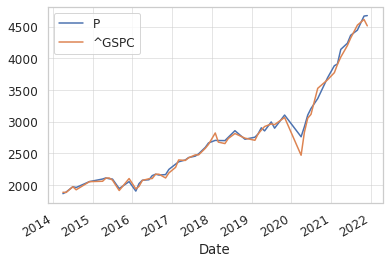

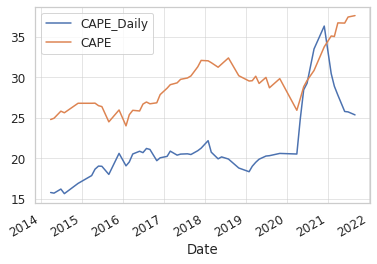

In [39]:
# make a daily CAPE
ticker_df_copy = ticker_df.set_index('Date', inplace=False)
cape_df_D = ticker_df_copy.join(cape_df)
cape_df_D = cape_df_D[date1:date2]

# backfill earnings
col = ['Earnings']
cape_df_D.loc[:,col] = cape_df_D.loc[:,col].bfill()

# make daily CAPE
cape_df_D['CAPE_Daily'] = cape_df_D['^GSPC'] / cape_df_D['Earnings']

# Compare Shiller's data to Yahoo's data
cape_df_D[['P', '^GSPC']].dropna().plot()
plt.show()

# compare CAPE_Daily and CAPE
cape_df_D[['CAPE_Daily', 'CAPE']].dropna().plot()
plt.show()
# close enough ¯\_(ツ)_/¯


# plotly graph... because it's sexy
# fig = px.line(cape_df_D[['CAPE_Daily', 'CAPE']].dropna())

# fig.show()


In [6]:
ticker_df = cape_df_D[['Open', 'High', 'Low', 'Adj Close', 'Volume', '^VIX', 'CAPE_Daily']]

ticker_df['pct_change'] = ticker_df['Adj Close'].pct_change()

# Are there for look ahead bias? Why 21?
# NK: good question... I don't recall ¯\_(ツ)_/¯ ....... taking it out for now

# ticker_df['^VIX'] = ticker_df['^VIX'].shift(21)
# ticker_df['CAPE_Daily'] = ticker_df['CAPE_Daily'].shift(21) 


#ticker_df['diff'] = ticker_df['Adj Close'].diff()
#ticker_df['5d_pct_change'] = ticker_df['Adj Close'].pct_change(periods=5)
#ticker_df['volume_pct_change'] = ticker_df['Volume'].pct_change()
#ticker_df['std'] = ticker_df['pct_change'].rolling(21).std()

ticker_df.dropna(inplace=True)
# ticker_df.set_index('Date', drop=True, inplace=True)

In [7]:
df_test = ticker_df.loc[:,['Open', 'High', 'Low', 'Adj Close', 'Volume', 'pct_change', '^VIX', 'CAPE_Daily']].copy()

df_test

,Open,High,Low,Adj Close,Volume,pct_change,^VIX,CAPE_Daily
Date,,,,,,,,
2014-01-03,183.229996,183.600006,182.630005,157.478119,81390600,-0.000164,13.760000,15.317255
2014-01-06,183.490005,183.559998,182.080002,157.021744,108028200,-0.002898,13.550000,15.278781
2014-01-07,183.089996,183.789993,182.949997,157.986145,86144200,0.006142,12.920000,15.371703
2014-01-08,183.449997,183.830002,182.889999,158.020538,96582300,0.000218,12.870000,15.368441
2014-01-09,184.110001,184.130005,182.800003,158.123901,90683400,0.000654,12.890000,15.373794
...,...,...,...,...,...,...,...,...
2021-08-26,448.609985,448.859985,446.160004,443.277557,57829600,-0.005903,18.840000,25.054866
2021-08-27,447.119995,450.649994,447.059998,447.240906,77201900,0.008941,16.389999,25.275540
2021-08-30,450.970001,453.070007,450.709991,449.207642,48357400,0.004397,16.190001,25.384391


In [22]:
df_test['log_CAPE_Daily'] = np.log(df_test['CAPE_Daily'])

# Train the model on a rolling basis (e.g. using obs from the past [x] years)
(yes I know looping through a DataFrame is inefficient - sorry

In [30]:
################
# OBSERVABLE VARIABLES INCLUDED IN HMM
################
obs_cols = ['^VIX', 'CAPE_Daily'] #'pct_change', 
################
# SET NUMBER OF STATES BELOW
################
components = 3
iterations = 10_000
################
# SET ROLLING LOOKBACK WINDOW FOR MODEL ESTIMATION BELOW
################
window = 250*1

total_rows = len(df_test)
ct = 0

df_test['state'] = np.nan

dats = []
transmats = {}

while ct+window <= total_rows:
    df_sub = df_test.iloc[ct:ct+window,:]
    dat = df_sub.iloc[-1:,:].index
    if len(obs_cols) == 1:
        X = np.column_stack([np.array(df_sub[obs_cols[0]])])
    else:
        X = np.array(df_sub[obs_cols[0]])
        for i in np.arange(1,len(obs_cols)):
            X = np.column_stack([X, df_sub[obs_cols[i]]])
    model = GaussianHMM(components, covariance_type="diag", n_iter=iterations)
    model.fit(X)
    # Optimal sequence of internal hidden state
    hidden_states = model.predict(X)
    df_test.loc[df_test.index == dat[0], 'state'] = hidden_states[-1]    
    # Daily transition matrix
    transmats[dat[0]] = model.transmat_[hidden_states[-1]]    
    ct = ct + 1

# (Rough) calculation of total returns under each state

In [31]:
df = df_test.copy()
# Yesterday's hidden state
df['state_plus_1'] = df.state.shift()

df['df'] = df['pct_change']+1
total_rets = {}
for s in np.arange(0, components):
    total_rets[s] = (df[df['state_plus_1'] == s]['df'].cumprod())
df.dropna(inplace=True)
print(f'Number of state changes: {(df.diff(axis=0) != 0).sum(axis=0)[0]}')

Number of state changes: 1675


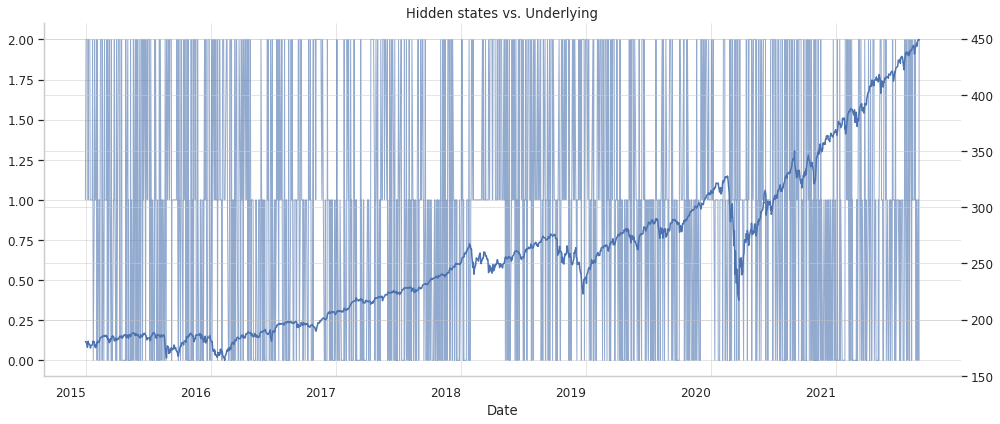

In [32]:
%matplotlib inline
ax1 = df['state_plus_1'].plot(alpha=0.6, title='Hidden states vs. Underlying', figsize=(14,6), lw=1, rot=0)

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df['Adj Close'].plot(ax=ax2)
plt.tight_layout()
sns.despine();

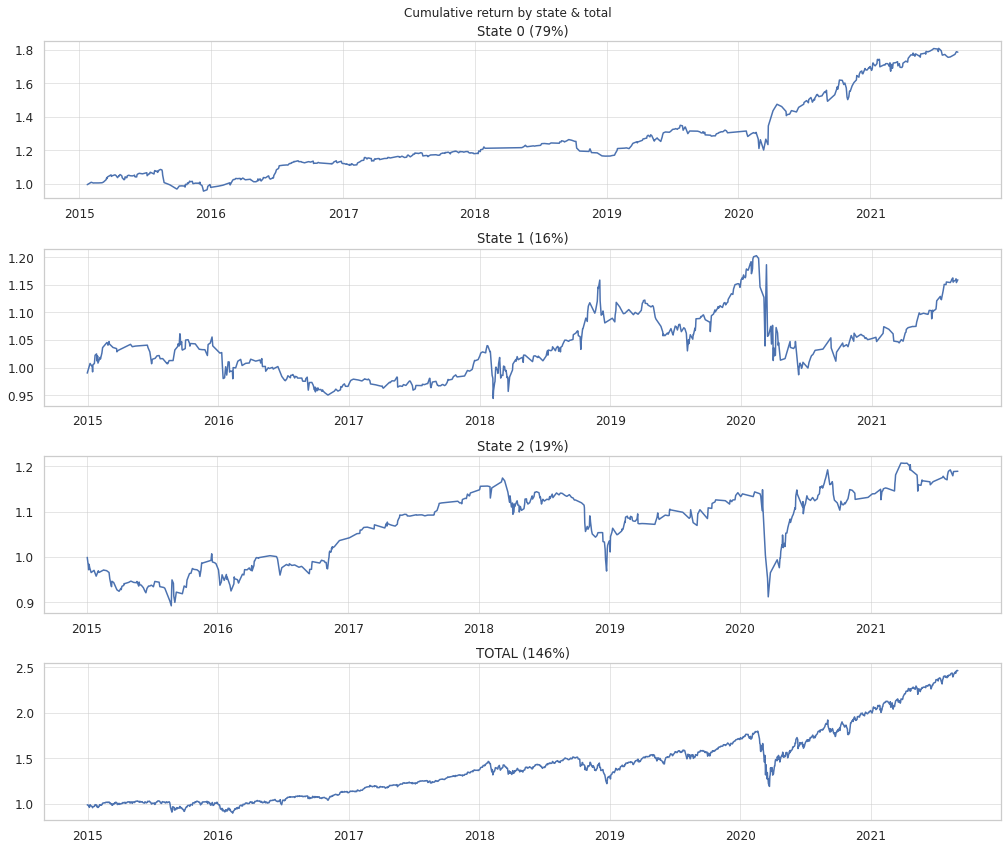

In [33]:
diffB = np.append([0], np.diff(df.state_plus_1))
up = np.where(diffB == 1)[0]
dn = np.where(diffB == -1)[0]
if diffB[np.argmax(diffB!=0)]==-1:
    # we have a falling edge before rising edge, must have started 'up'
    up = np.append([0], up)
if diffB[len(diffB) - np.argmax(diffB[::-1]) - 1]==1:
    # we have a rising edge that never fell, force it 'dn'
    dn = np.append(dn, [len(df.state_plus_1)-1])

fig, axes = plt.subplots(components+1, 1, figsize=(14,12))
for row in range(components):
    ax = axes[row]
    ax.plot(total_rets[row])
    ax.set_title(f'State {row} ({round((total_rets[row][-1]-1)*100)}%)')

ax = axes[components]
ax.plot(df['df'].cumprod())

# for i in range(len(up)):
#     ax.axvspan(df.index[up[i]], df.index[dn[i]], color='r', alpha=0.4, lw=0)
    
tot = df['df'].cumprod()
ax.set_title(f'TOTAL ({round((tot[-1]-1)*100)}%)')

fig.suptitle('Cumulative return by state & total')
fig.tight_layout()
plt.show()

In [34]:
for i in range(0, len(total_rets)):
    print('----------------------------------------------------')
    print(f'State {i}')
    print('----------------------------------------------------')
    qs.reports.metrics(total_rets[i].pct_change().dropna(), mode="basic")
    print('\n\n')

print('----------------------------------------------------')
print(f'TOTAL (sense check)')
print('----------------------------------------------------')
qs.reports.metrics(tot.pct_change(), 'SPY', mode="basic")


----------------------------------------------------
State 0
----------------------------------------------------
                    Strategy
------------------  ----------
Start Period        2015-02-03
End Period          2021-08-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   79.56%
CAGR﹪              9.31%

Sharpe              1.63
Sortino             2.56
Sortino/√2          1.81
Omega               1.39

Max Drawdown        -11.92%
Longest DD Days     323

Gain/Pain Ratio     0.39
Gain/Pain (1M)      1.21

Payoff Ratio        1.02
Profit Factor       1.39
Common Sense Ratio  1.38
CPC Index           0.82
Tail Ratio          0.99
Outlier Win Ratio   3.67
Outlier Loss Ratio  4.79

MTD                 1.26%
3M                  0.45%
6M                  6.81%
YTD                 5.05%
1Y                  15.26%
3Y (ann.)           12.47%
5Y (ann.)           9.58%
10Y (ann.)          9.31%
All-time (ann.)     9.31%

Avg. Drawdown       -158.92%
Avg. Drawdo

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2015-02-03  2015-02-03
End Period                 2021-08-31  2021-08-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      99.0%

Cumulative Return          79.56%      149.43%
CAGR﹪                     9.31%       14.91%

Sharpe                     1.63        1.63
Smart Sharpe               1.6         1.6
Sortino                    2.56        2.3
Smart Sortino              2.5         2.25
Sortino/√2                 1.81        1.62
Smart Sortino/√2           1.77        1.59
Omega                      1.39        1.39

Max Drawdown               -11.92%     -33.72%
Longest DD Days            323         273
Volatility (ann.)          16.21%      26.15%
R^2                        0.39        0.39
Calmar                     0.78        0.44
Skew                       1.12        -1.05
Kurtosis                   16.42       14

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-08-18,2015-12-11,2016-07-06,323,-11.916591,-11.189982
2,2019-07-30,2020-03-11,2020-04-06,251,-10.966925,-10.289349
3,2018-09-26,2018-12-28,2019-04-12,198,-7.812550,-7.776934
4,2020-10-15,2020-10-30,2020-11-23,39,-7.225240,-6.247885
5,2020-04-30,2020-05-13,2020-06-30,61,-4.622843,-4.184422


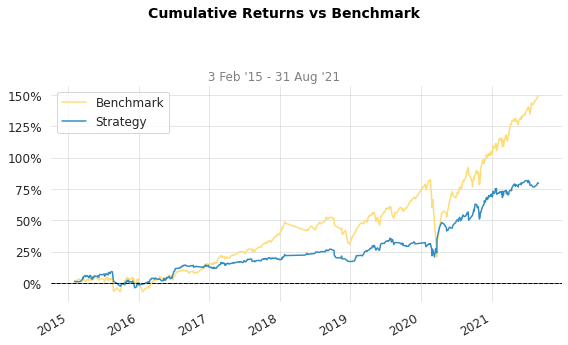

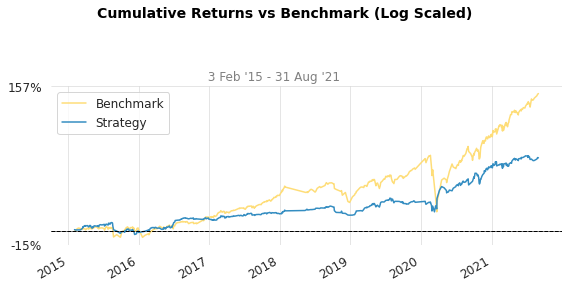

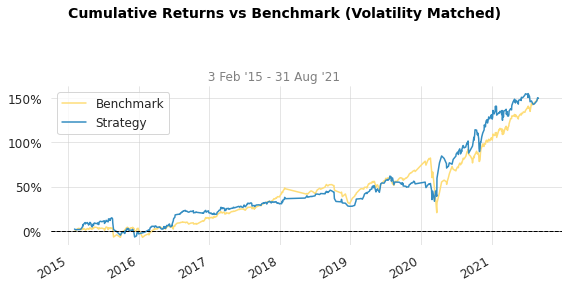

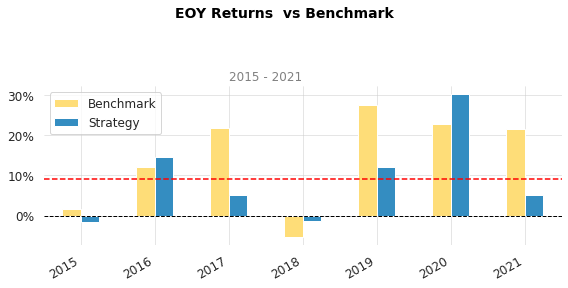

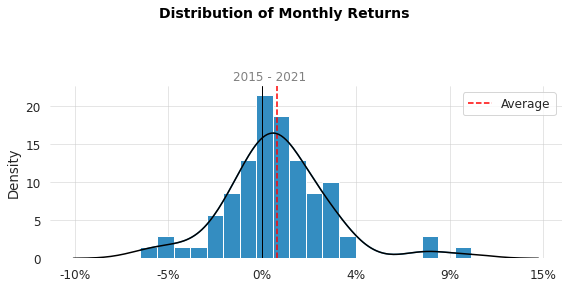

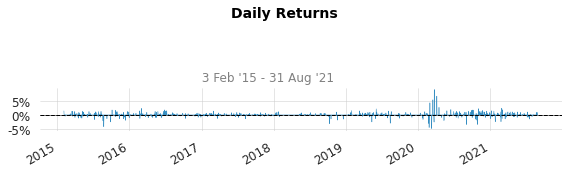

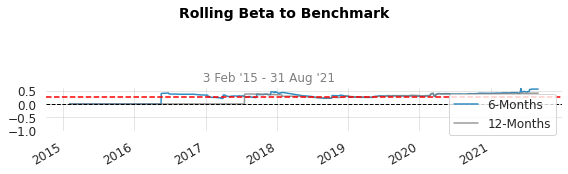

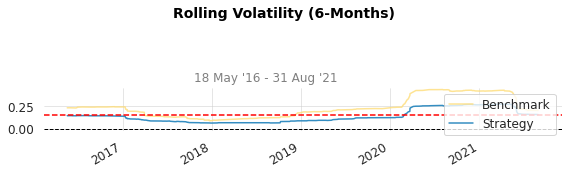

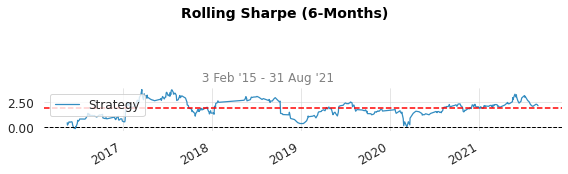

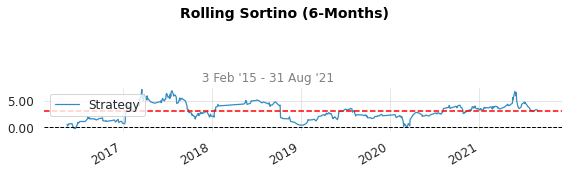

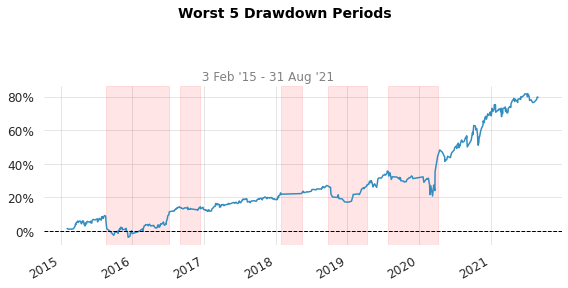

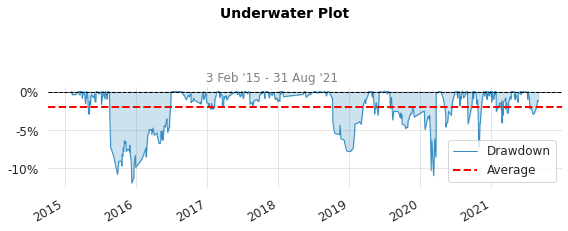

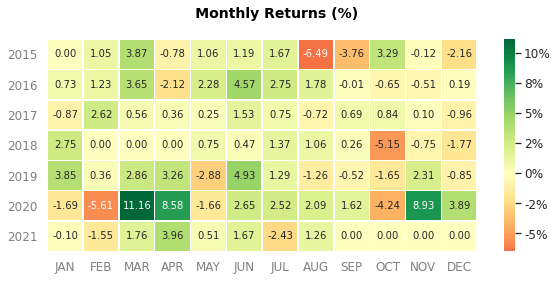

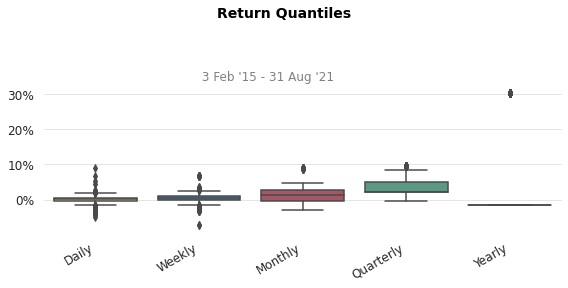

In [35]:
qs.reports.full(total_rets[0].pct_change().dropna(), "SPY")